In [1]:
import os
os.chdir("/home/mohsen/projects/scarches/")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import scanpy as sc
import numpy as np
import scarches as sca

/home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
Using TensorFlow backend.


In [4]:
sc.settings.set_figure_params(dpi=200)

In [5]:
condition_key = "study"
cell_type_key = 'cell_type'
target_conditions = ["Pancreas SS2", "Pancreas CelSeq2"]
target_cell_types = ['Pancreas Alpha']

In [6]:
sc.settings.figdir = "./results/outofsample/pancreas_alpha/"

# Loading 5 Pancreas datasets and data preparation

In [8]:
adata = sc.read("/home/mohsen/data/pancreas/pancreas_normalized.h5ad")
adata

AnnData object with n_obs × n_vars = 15681 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

## Number of cells in each batch

In [9]:
adata.obs[condition_key].value_counts()

Pancreas inDrop         8391
Pancreas SS2            2961
Pancreas CelSeq2        2426
Pancreas CelSeq         1271
Pancreas Fluidigm C1     632
Name: study, dtype: int64

In [10]:
batch_colors = sc.pl.palettes.zeileis_28[:5]

In [11]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 10294 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [12]:
adata_for_training = adata_for_training[~adata_for_training.obs[cell_type_key].isin(target_cell_types)]
adata_for_training

View of AnnData object with n_obs × n_vars = 7584 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [13]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 5387 × 1000 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [16]:
conditions = adata_for_training.obs[condition_key].unique().tolist()
conditions

['Pancreas inDrop', 'Pancreas CelSeq', 'Pancreas Fluidigm C1']

# Create & Train model with training data

In [18]:
network = sca.models.scArches(task_name='pancreas_oos_alpha_before',
                              x_dimension=adata_for_training.shape[1], 
                              z_dimension=10,
                              architecture=[128, 20],
                              conditions=conditions,
                              gene_names=adata_for_training.var_names.tolist(),
                              use_batchnorm=False,
                              lr=0.001,
                              alpha=0.001,
                              beta=200,
                              clip_value=1e6,
                              eta=1.0,
                              loss_fn='mse',
                              model_path=f"./models/OoS/pancreas/before/",
                              dropout_rate=0.05,
                              output_activation='relu')

W0726 19:08:02.693920 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0726 19:08:02.696063 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0726 19:08:02.697225 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0726 19:08:03.036555 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!


## Training the network

In [19]:
network.train(adata_for_training,
              train_size=0.8, 
              condition_key=condition_key,
              n_epochs=10000,
              batch_size=512, 
              early_stop_limit=50,
              lr_reducer=40, 
              save=True,
              retrain=True)

W0726 19:08:29.233498 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0726 19:08:29.445717 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0726 19:08:29.674470 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W0726 19:08:30.254934 140357938501440 module_wrapper.py:139] From /home/mohsen/anaconda3/envs/mohsen/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:206: The name tf.variables_initializer is deprecated. Plea

 |--------------------| 3.6%  - loss: 7.3478 - mmd_loss: 5.4814 - reconstruction_loss: 1.8664 - val_loss: 7.6591 - val_mmd_loss: 5.7753 - val_reconstruction_loss: 1.88372919
scArches has been successfully saved in ./models/OoS/pancreas/before/pancreas_oos_alpha_before.


In [20]:
network.condition_encoder

{'Pancreas CelSeq': 0, 'Pancreas Fluidigm C1': 1, 'Pancreas inDrop': 2}

In [21]:
latent_adata = network.get_latent(adata_for_training, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 7584 × 20 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [22]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

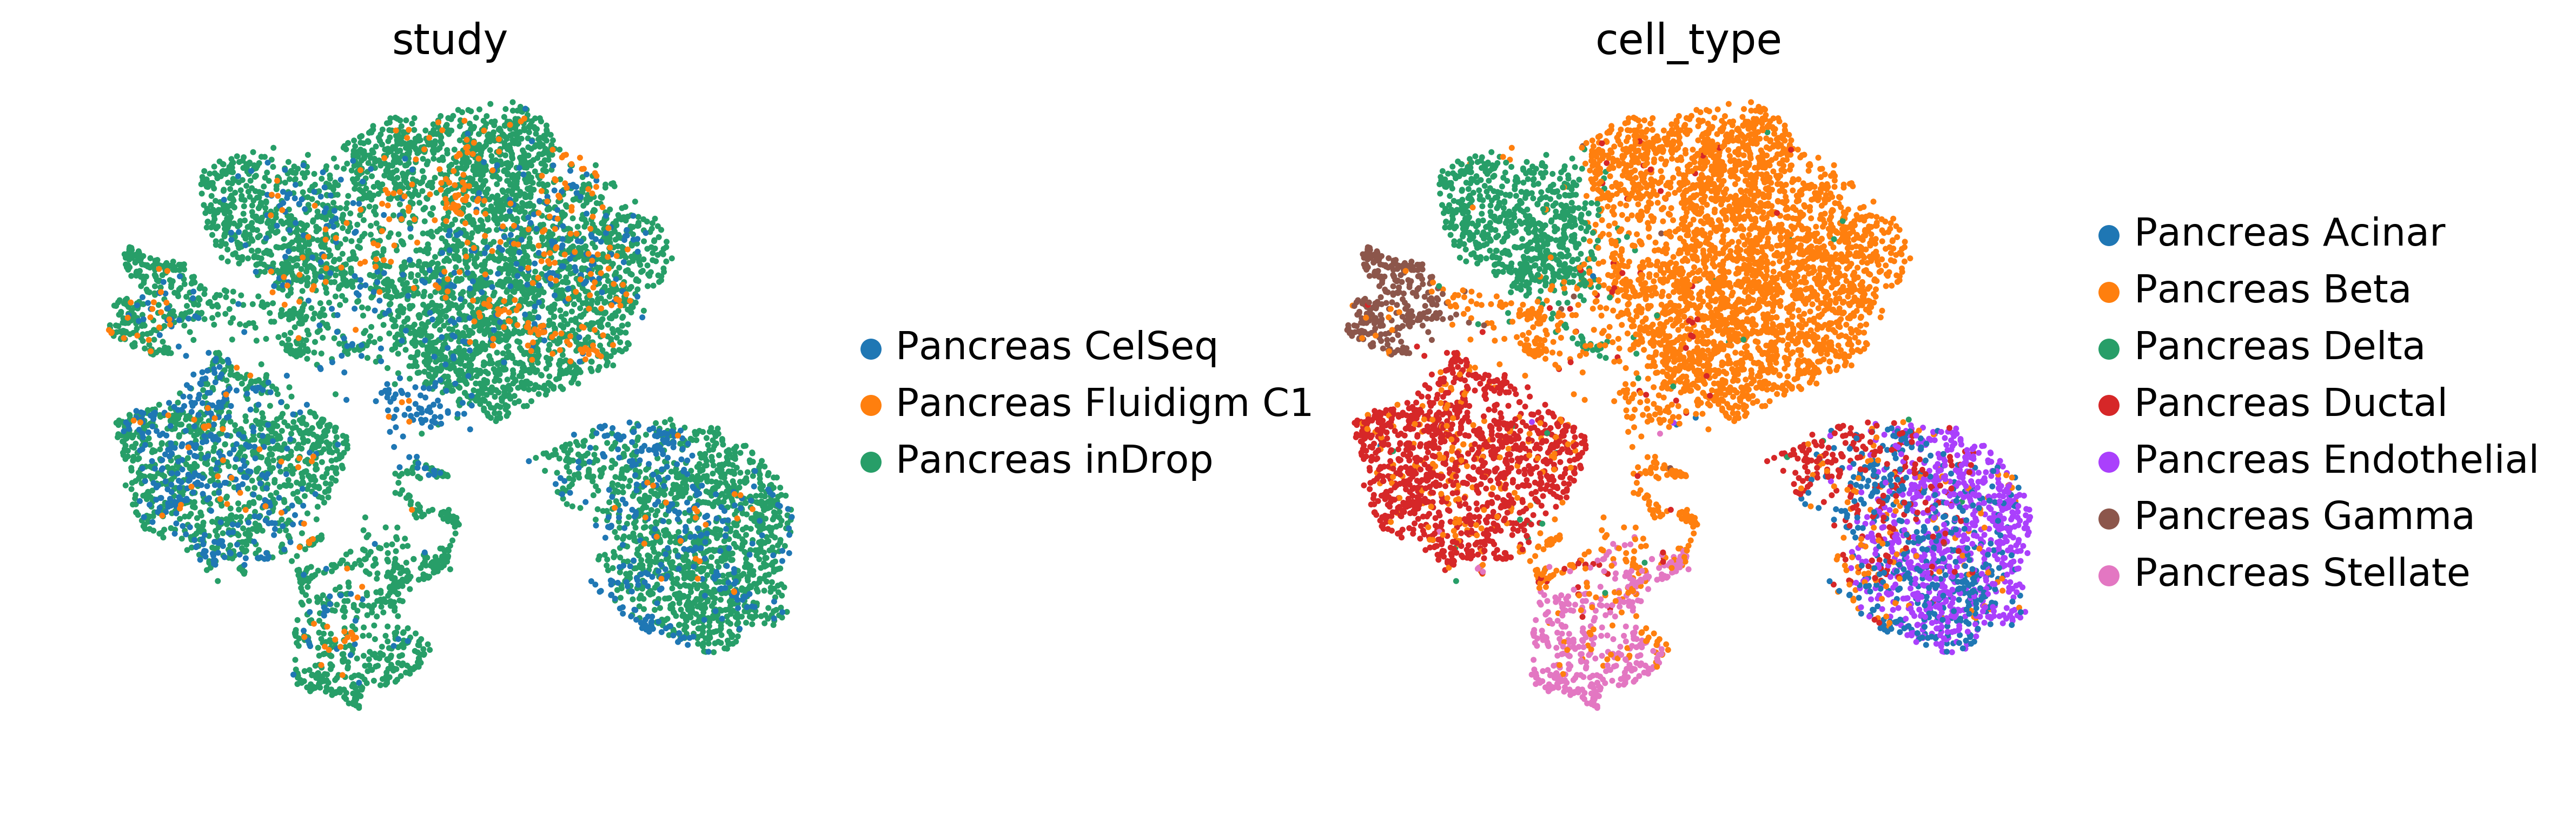

In [23]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False)

In [25]:
palette = ['#023fa5', '#bec1d4','#bb7784']

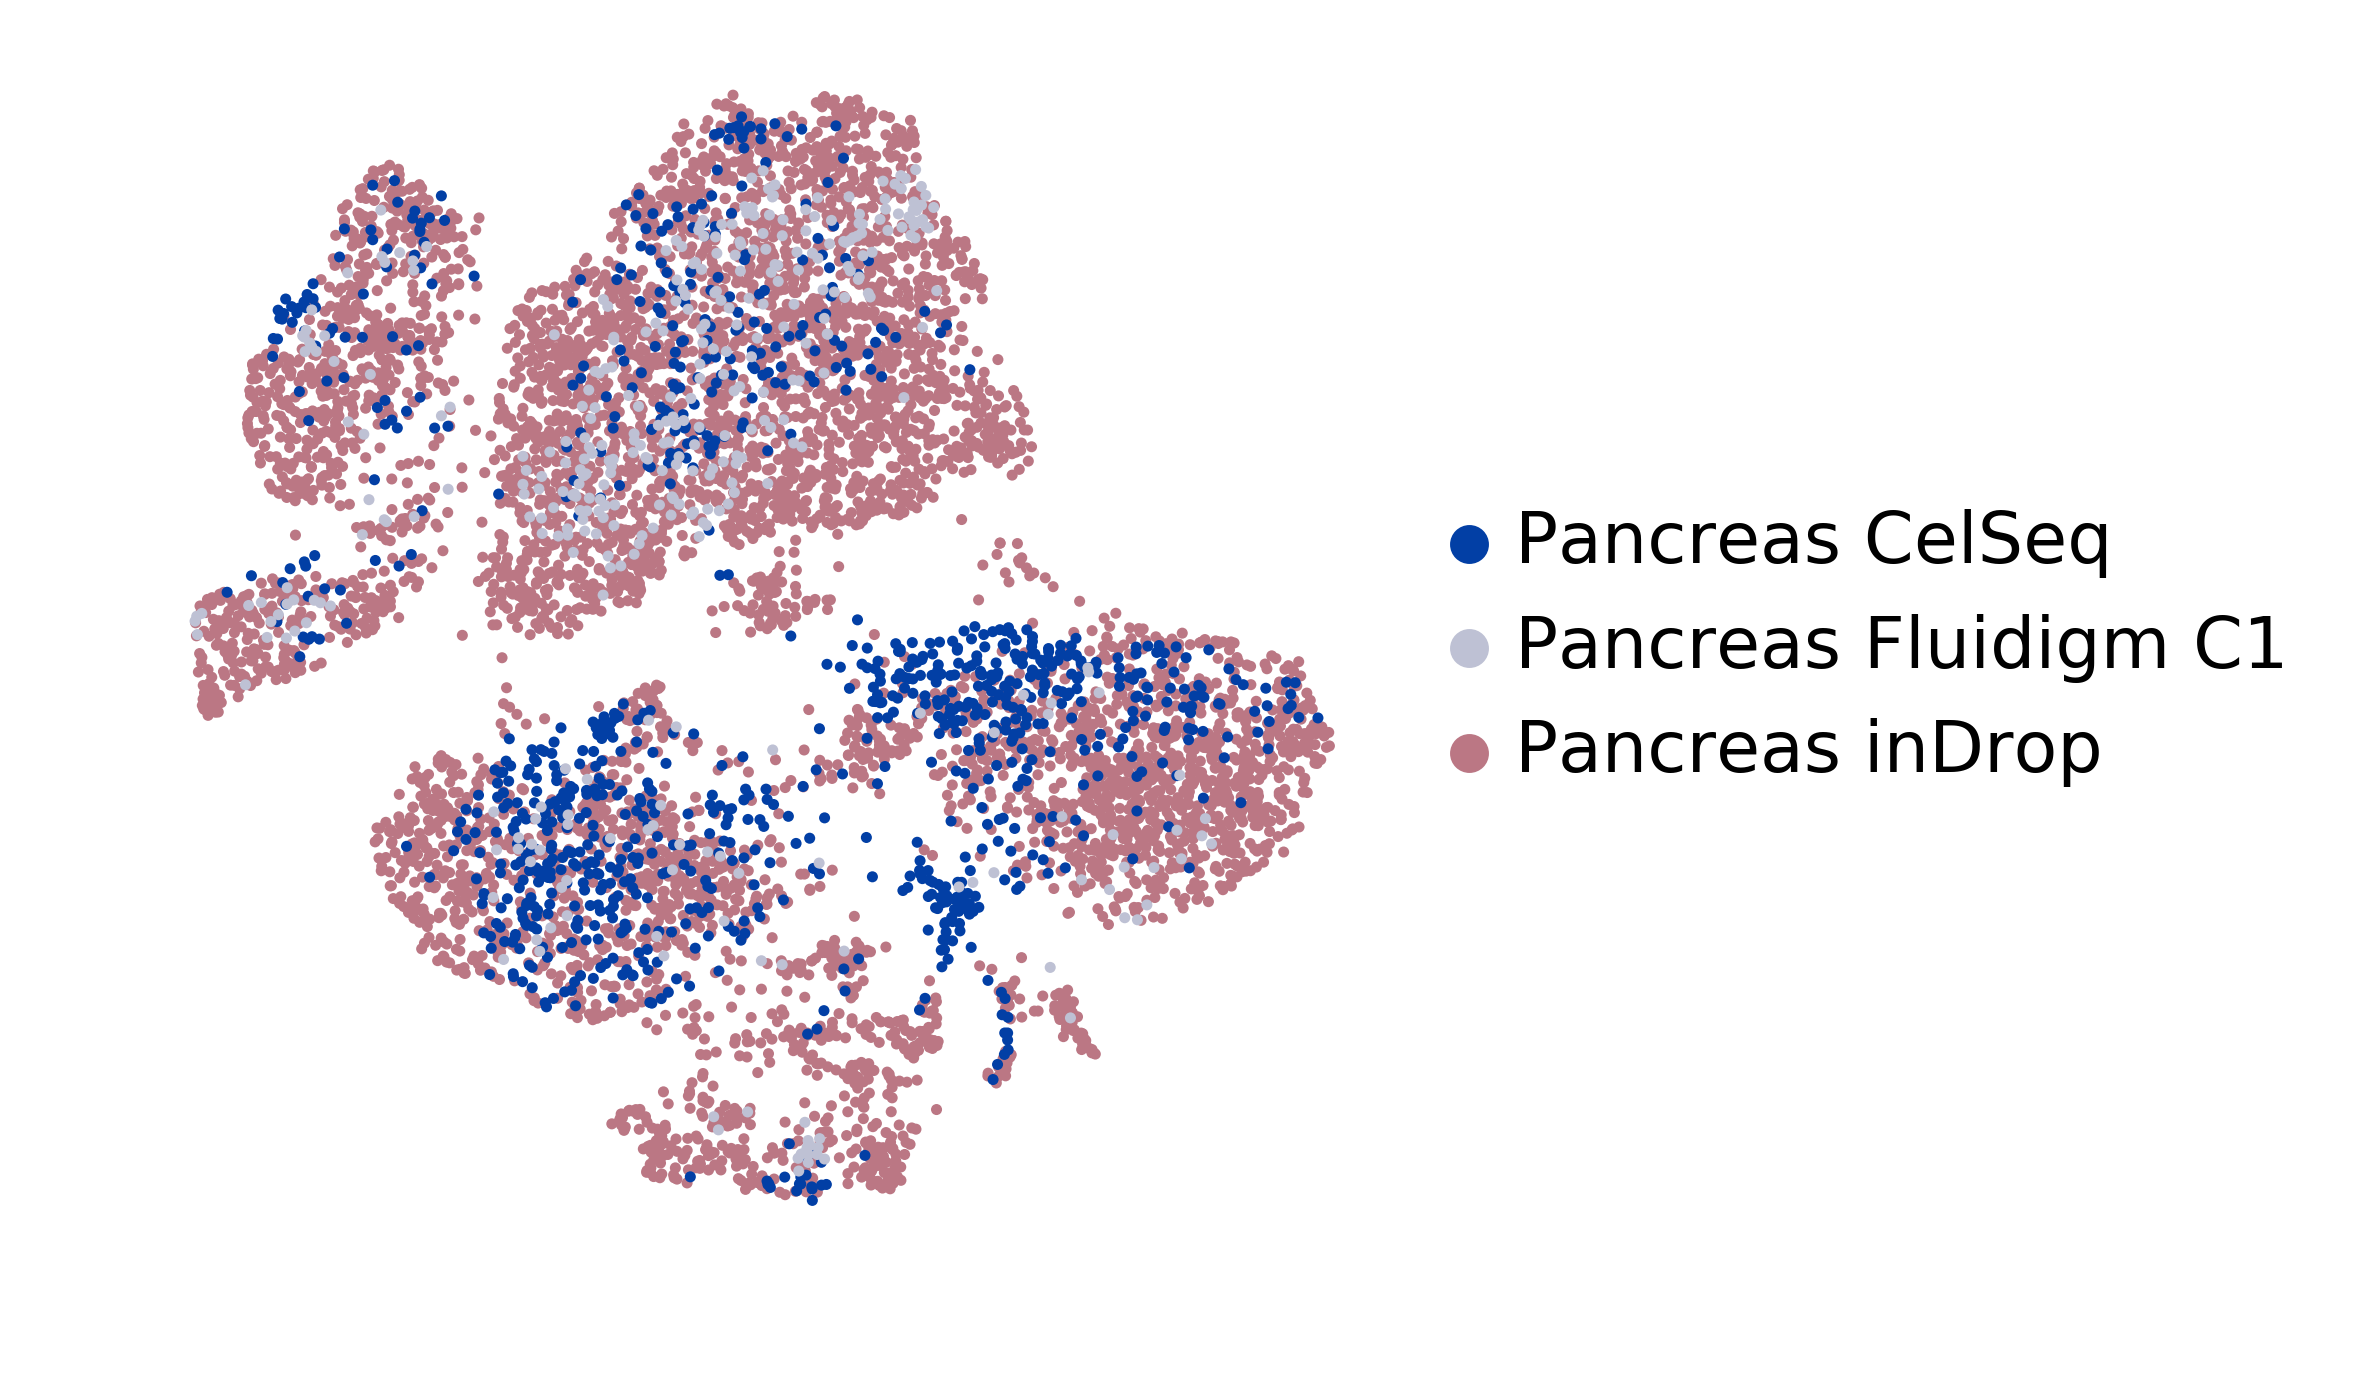

In [26]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_before.pdf", palette=palette)

In [27]:
palette = sc.pl.palettes.godsnot_102[:1] + sc.pl.palettes.godsnot_102[2:]

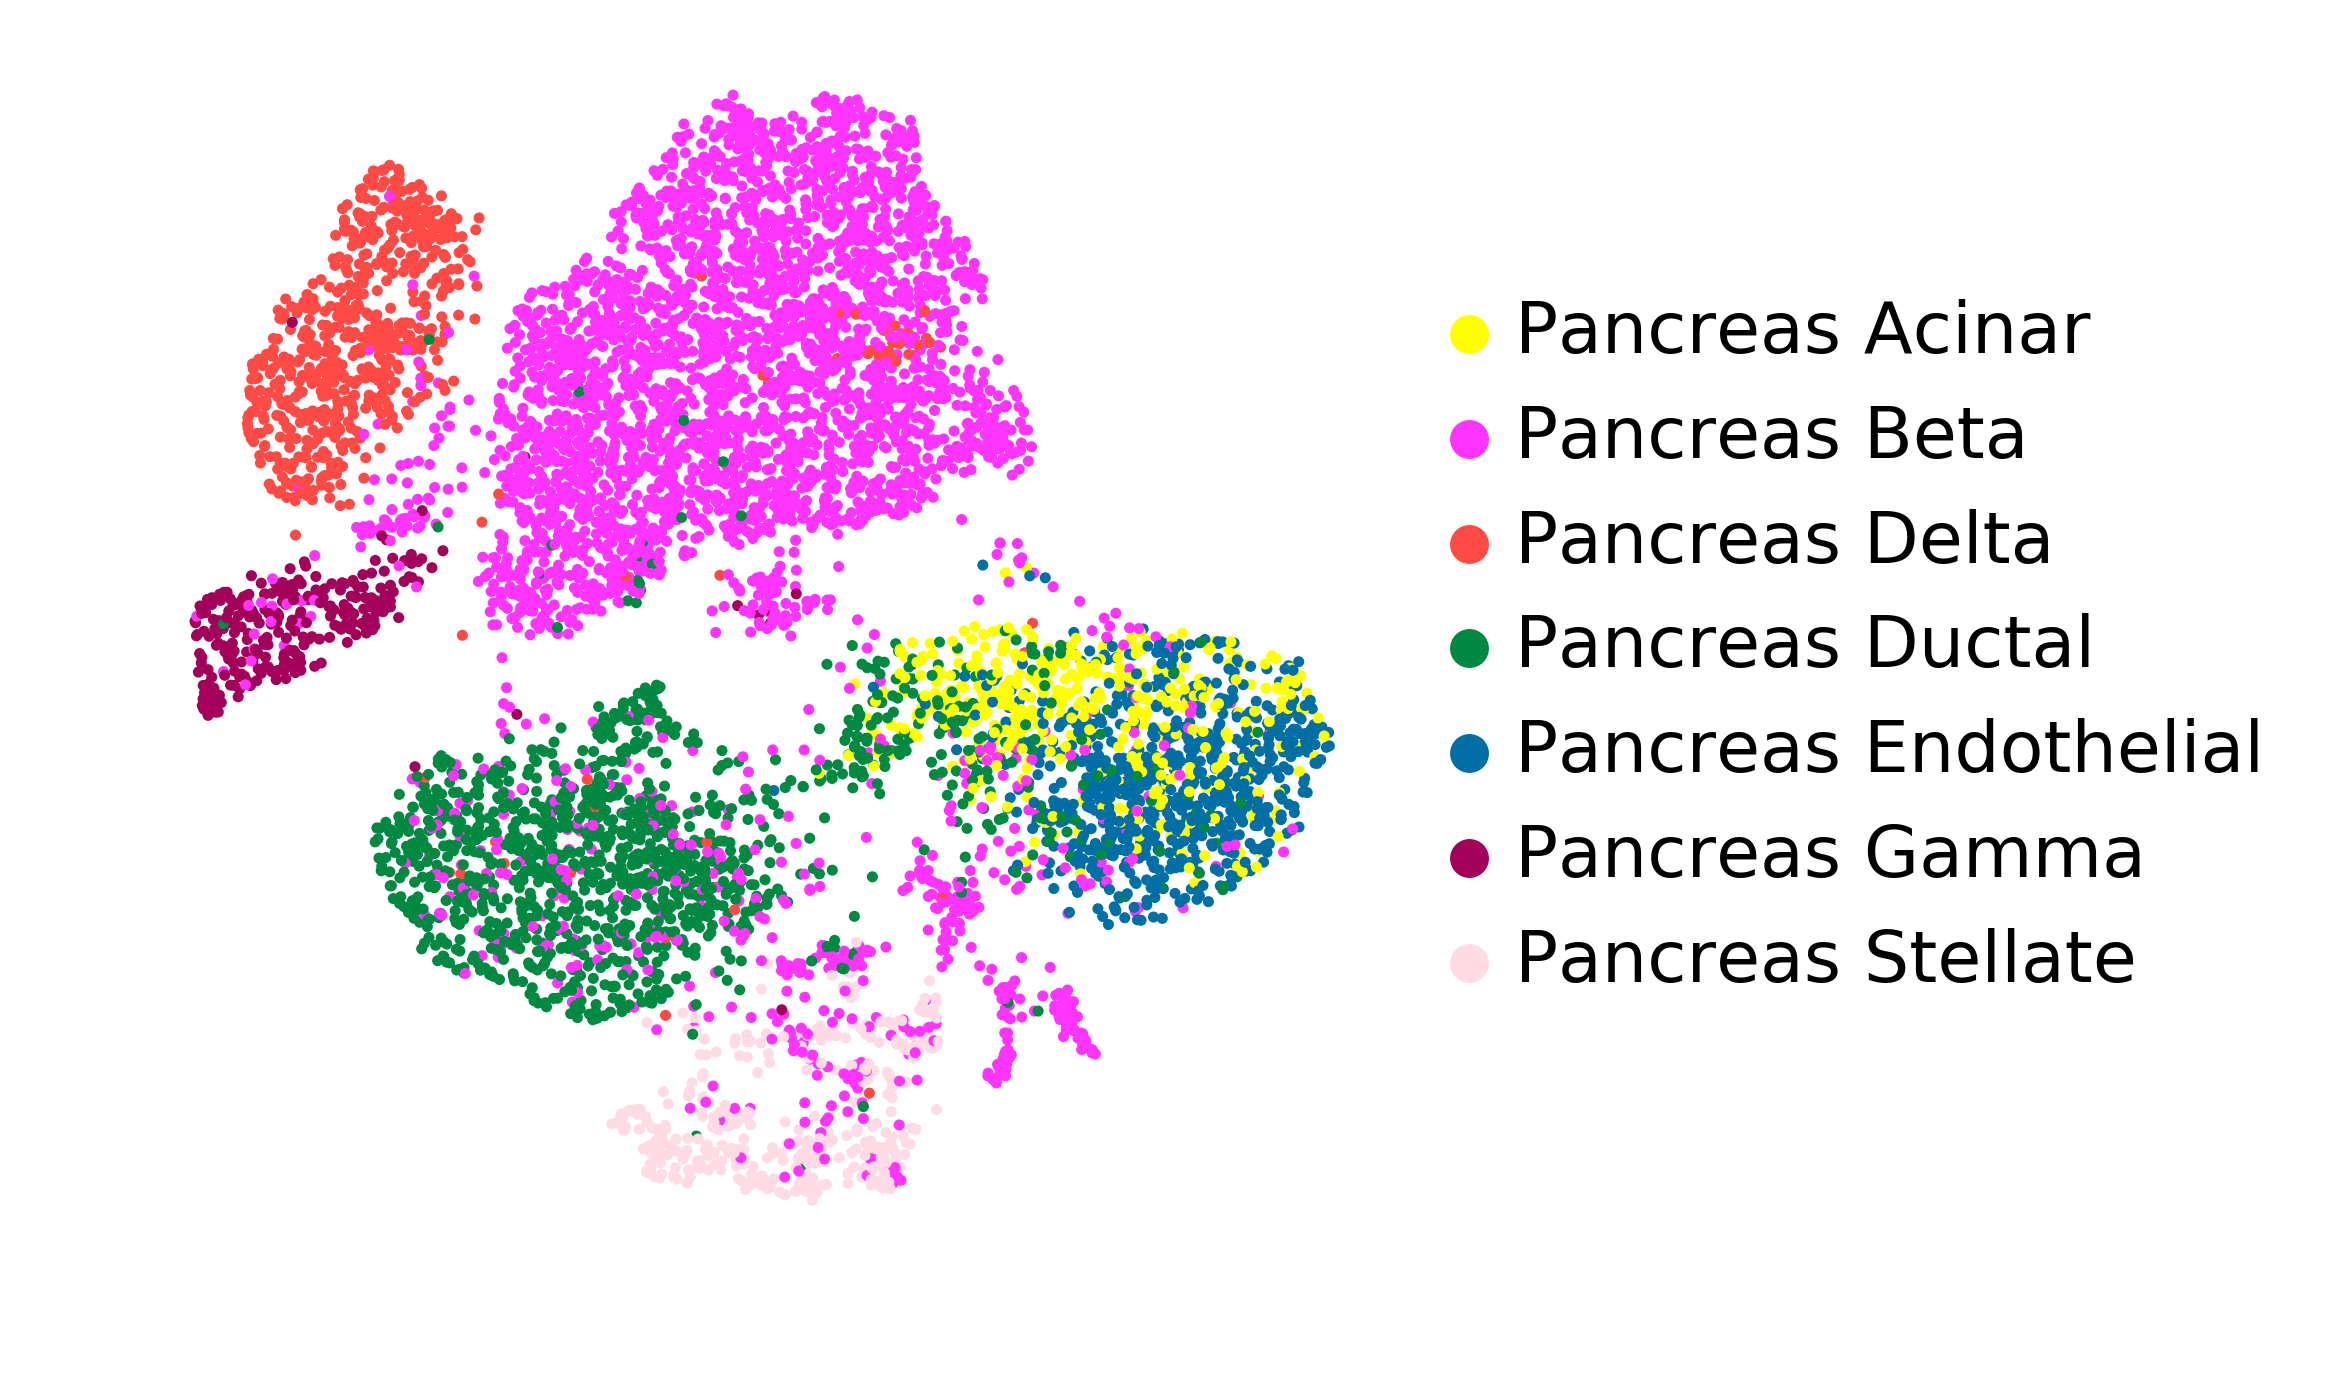

In [28]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_before.pdf", palette=palette)

# Perfroming architecture Surgery

In [22]:
new_network = sca.operate(network, 
                          new_task_name='pancreas_oos_after',
                          new_conditions=target_conditions,
                          init='Xavier',
                          version='scArches',
                          remove_dropout=True,
                          new_training_kwargs={"beta": 500},
                          print_summary=False,
                          )

scArches' network has been successfully constructed!
scArches' network has been successfully compiled!
scArches' network has been successfully compiled!


In [23]:
new_network.condition_encoder

{'Pancreas CelSeq': 0,
 'Pancreas Fluidigm C1': 1,
 'Pancreas inDrop': 2,
 'Pancreas SS2': 3,
 'Pancreas CelSeq2': 4}

## Train with small new dataset containing out-of-sample condition

In [24]:
new_network.train(adata_out_of_sample,
                  train_size=0.8, 
                  condition_key=condition_key,
                  n_epochs=10000,
                  batch_size=1024, 
                  early_stop_limit=50,
                  lr_reducer=40, 
                  save=True,
                  retrain=True)

 |█-------------------| 7.6%  - loss: 3.1311 - mmd_loss: 0.7697 - reconstruction_loss: 2.3614 - val_loss: 3.5289 - val_mmd_loss: 1.1642 - val_reconstruction_loss: 2.364786194679
scArches has been successfully saved in ./models/OoS/pancreas/before/pancreas_oos_after.


In [25]:
latent_adata_after = new_network.get_latent(adata_out_of_sample, condition_key, return_z=False)
latent_adata_after

AnnData object with n_obs × n_vars = 5387 × 20 
    obs: 'batch', 'study', 'cell_type', 'size_factors'

In [32]:
sc.pp.neighbors(latent_adata_after)
sc.tl.umap(latent_adata_after)

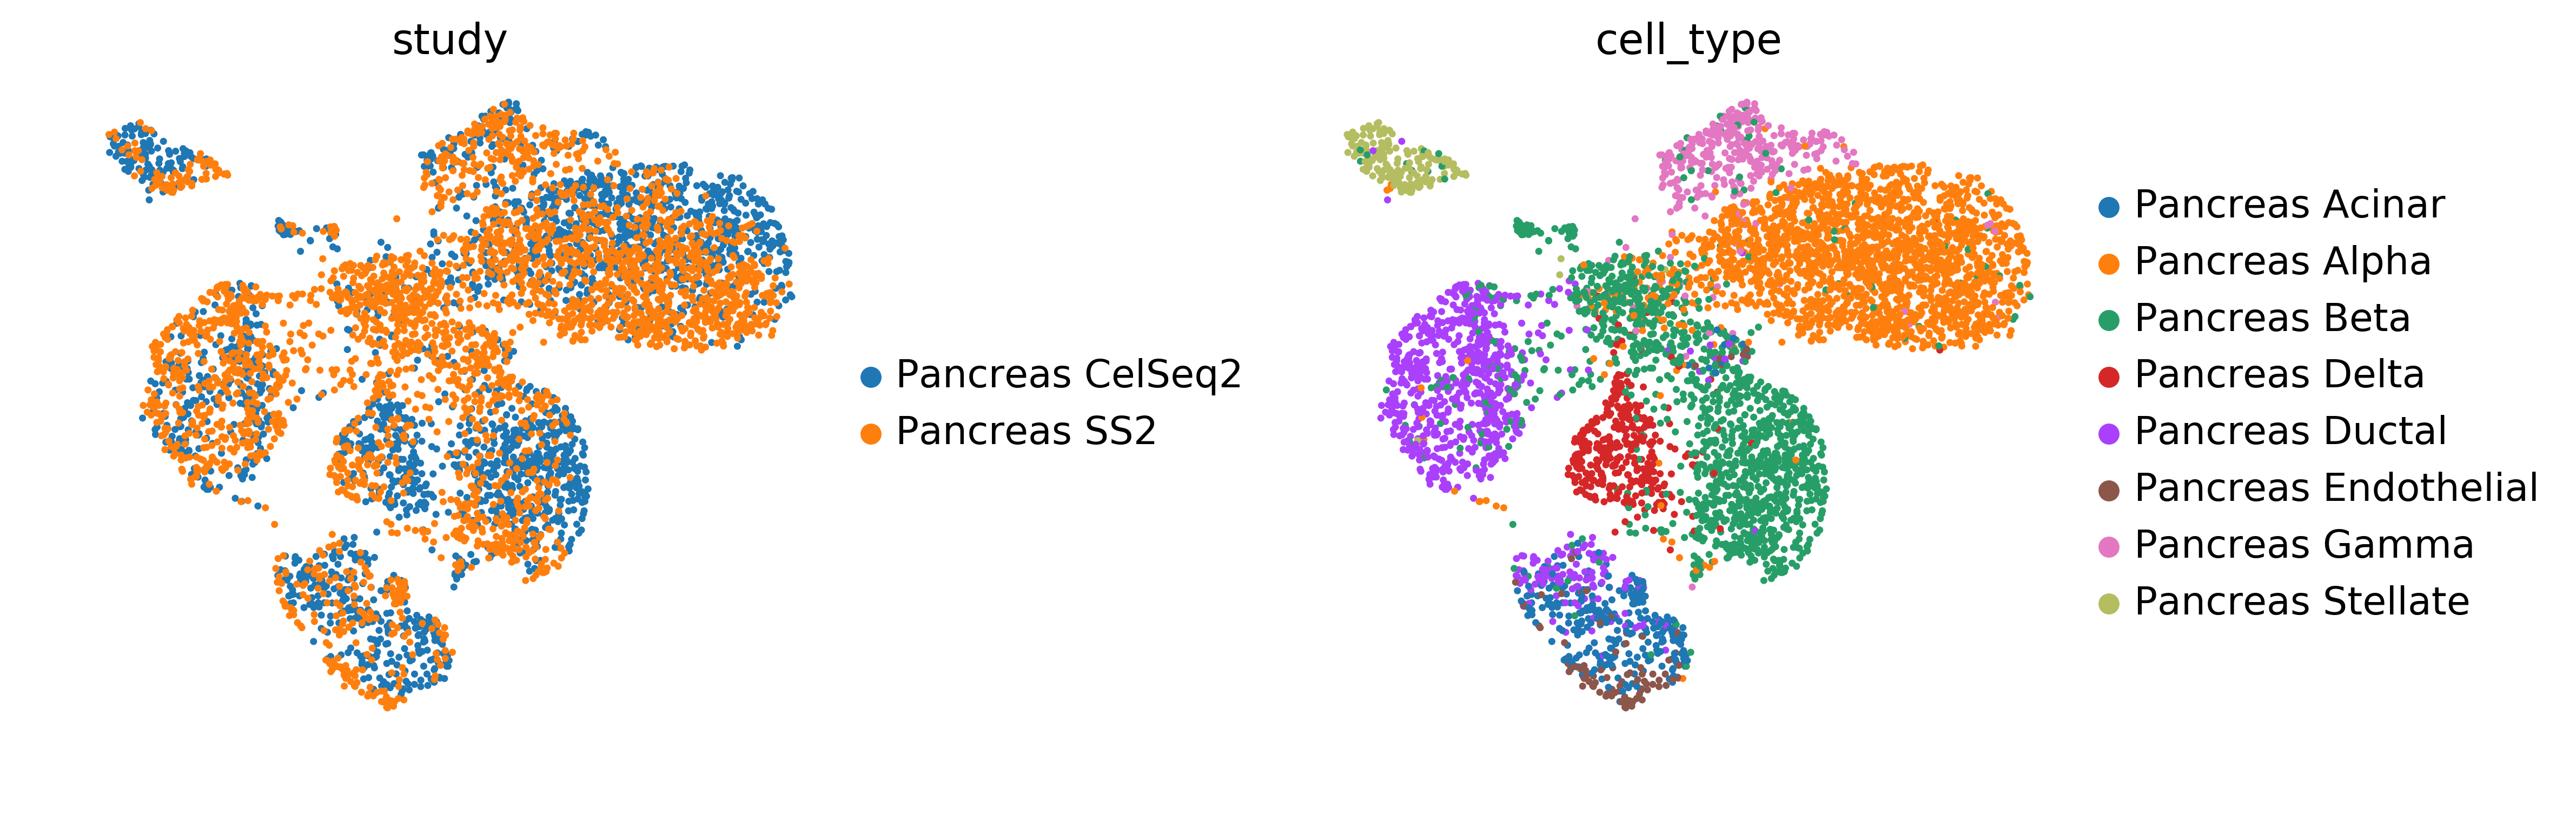

In [33]:
sc.pl.umap(latent_adata_after, color=[condition_key, cell_type_key], wspace=0.5, frameon=False, )

In [39]:
palette = ['#7d87b9', '#d6bcc0']

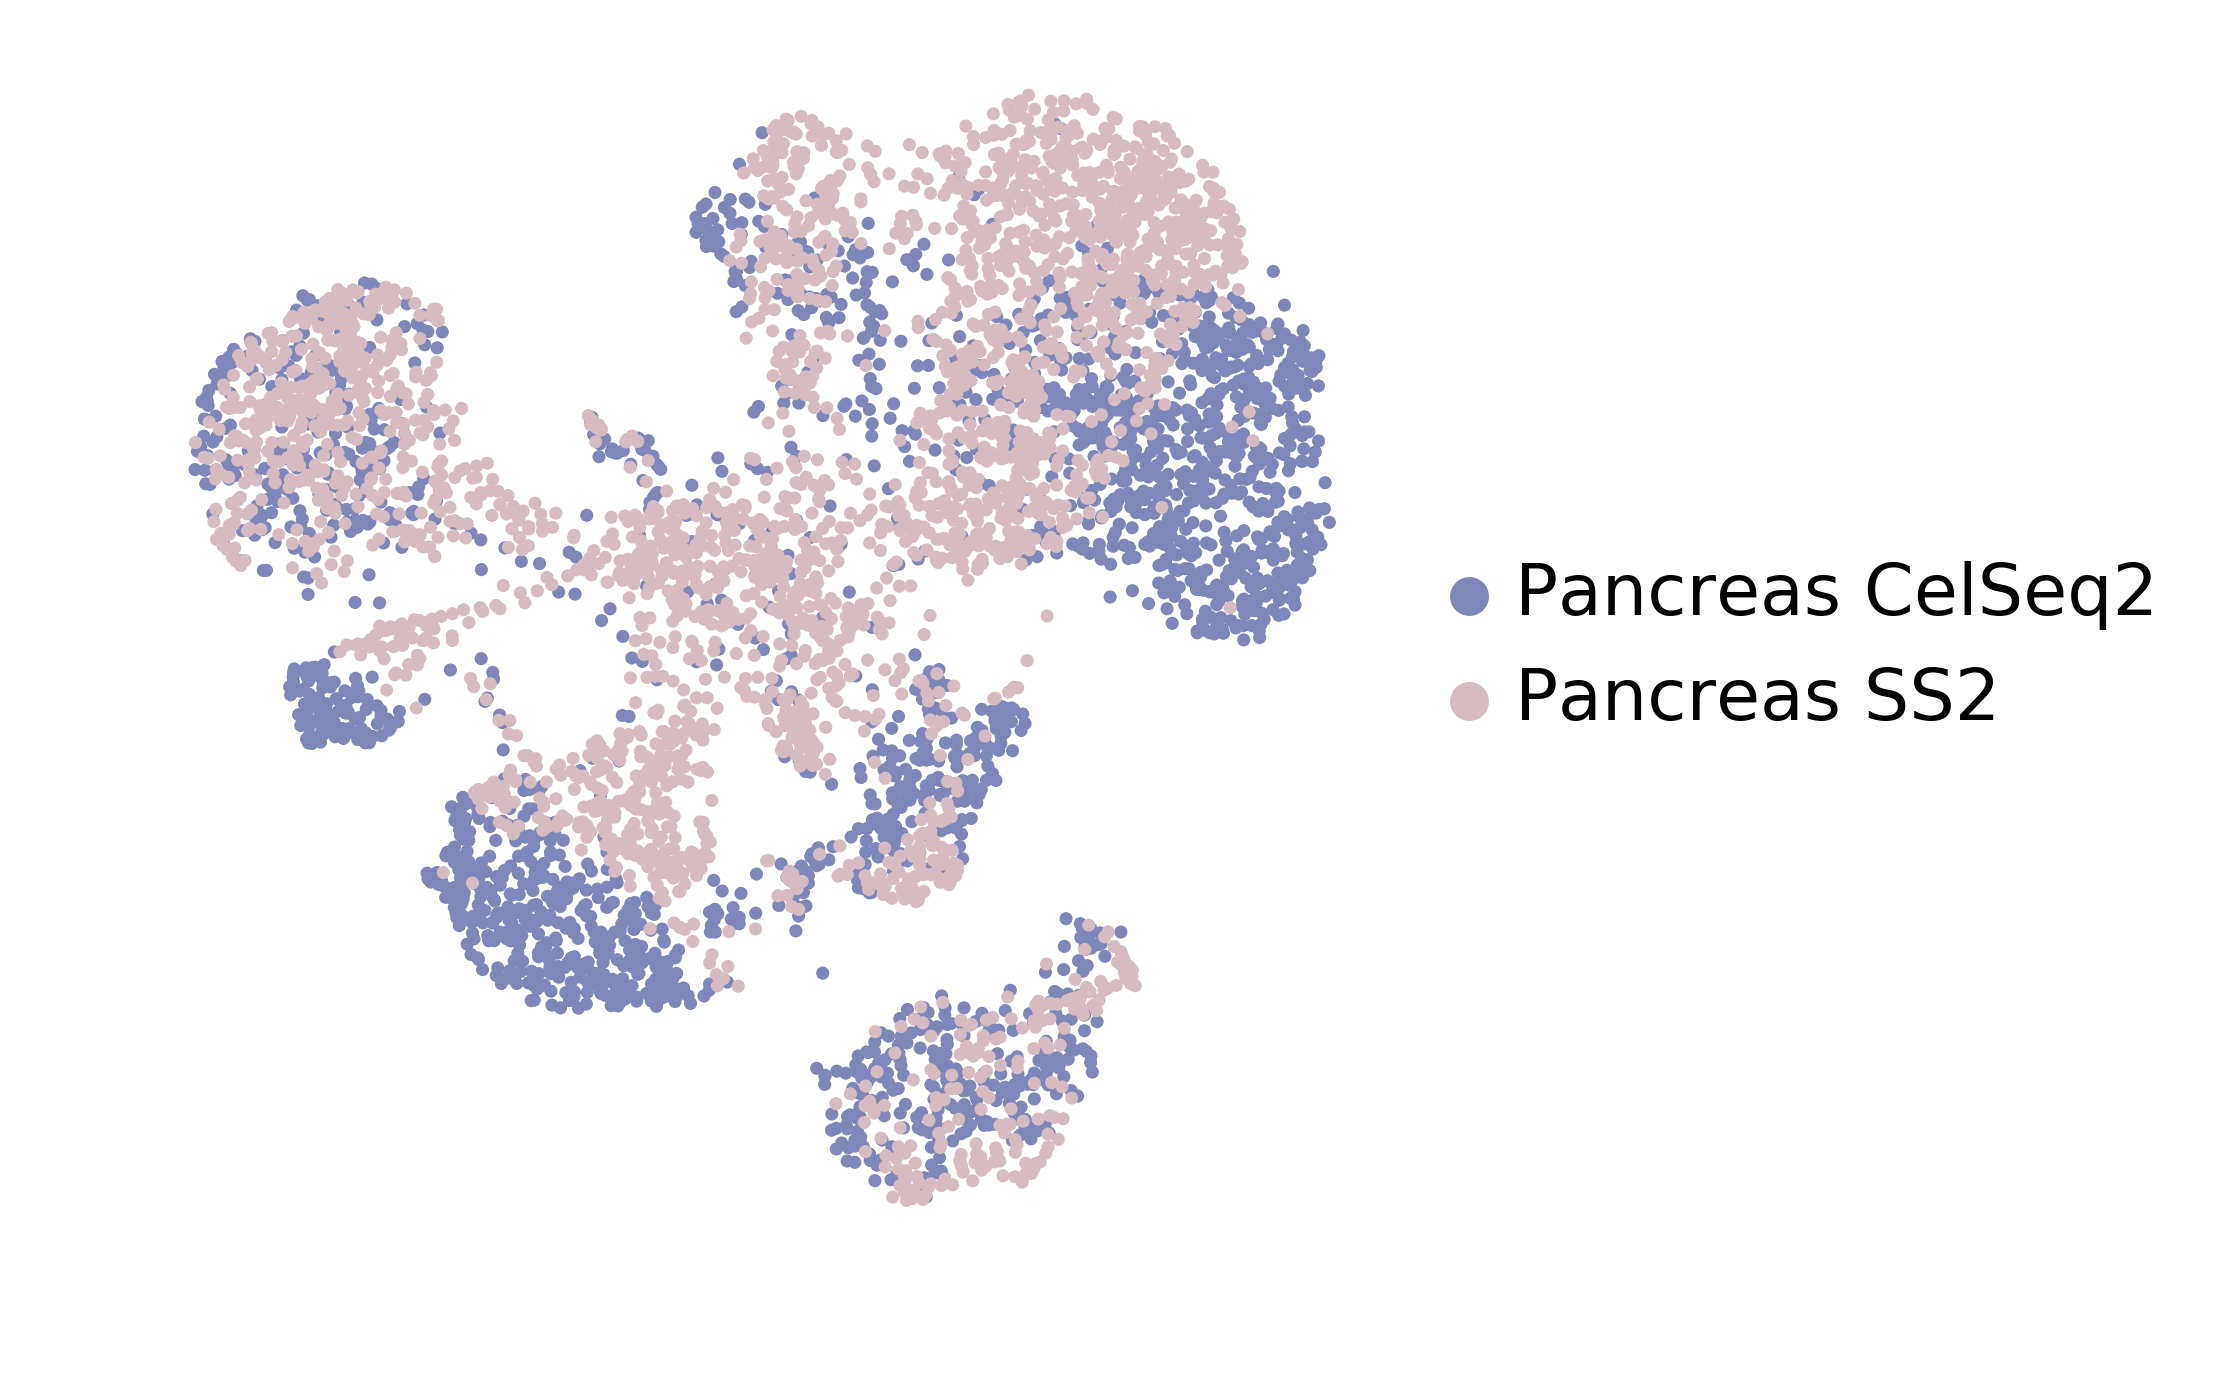

In [40]:
sc.pl.umap(latent_adata_after, color=[condition_key], frameon=False, title="", 
           save="_condition_out_of_sample_after.pdf", palette=palette)

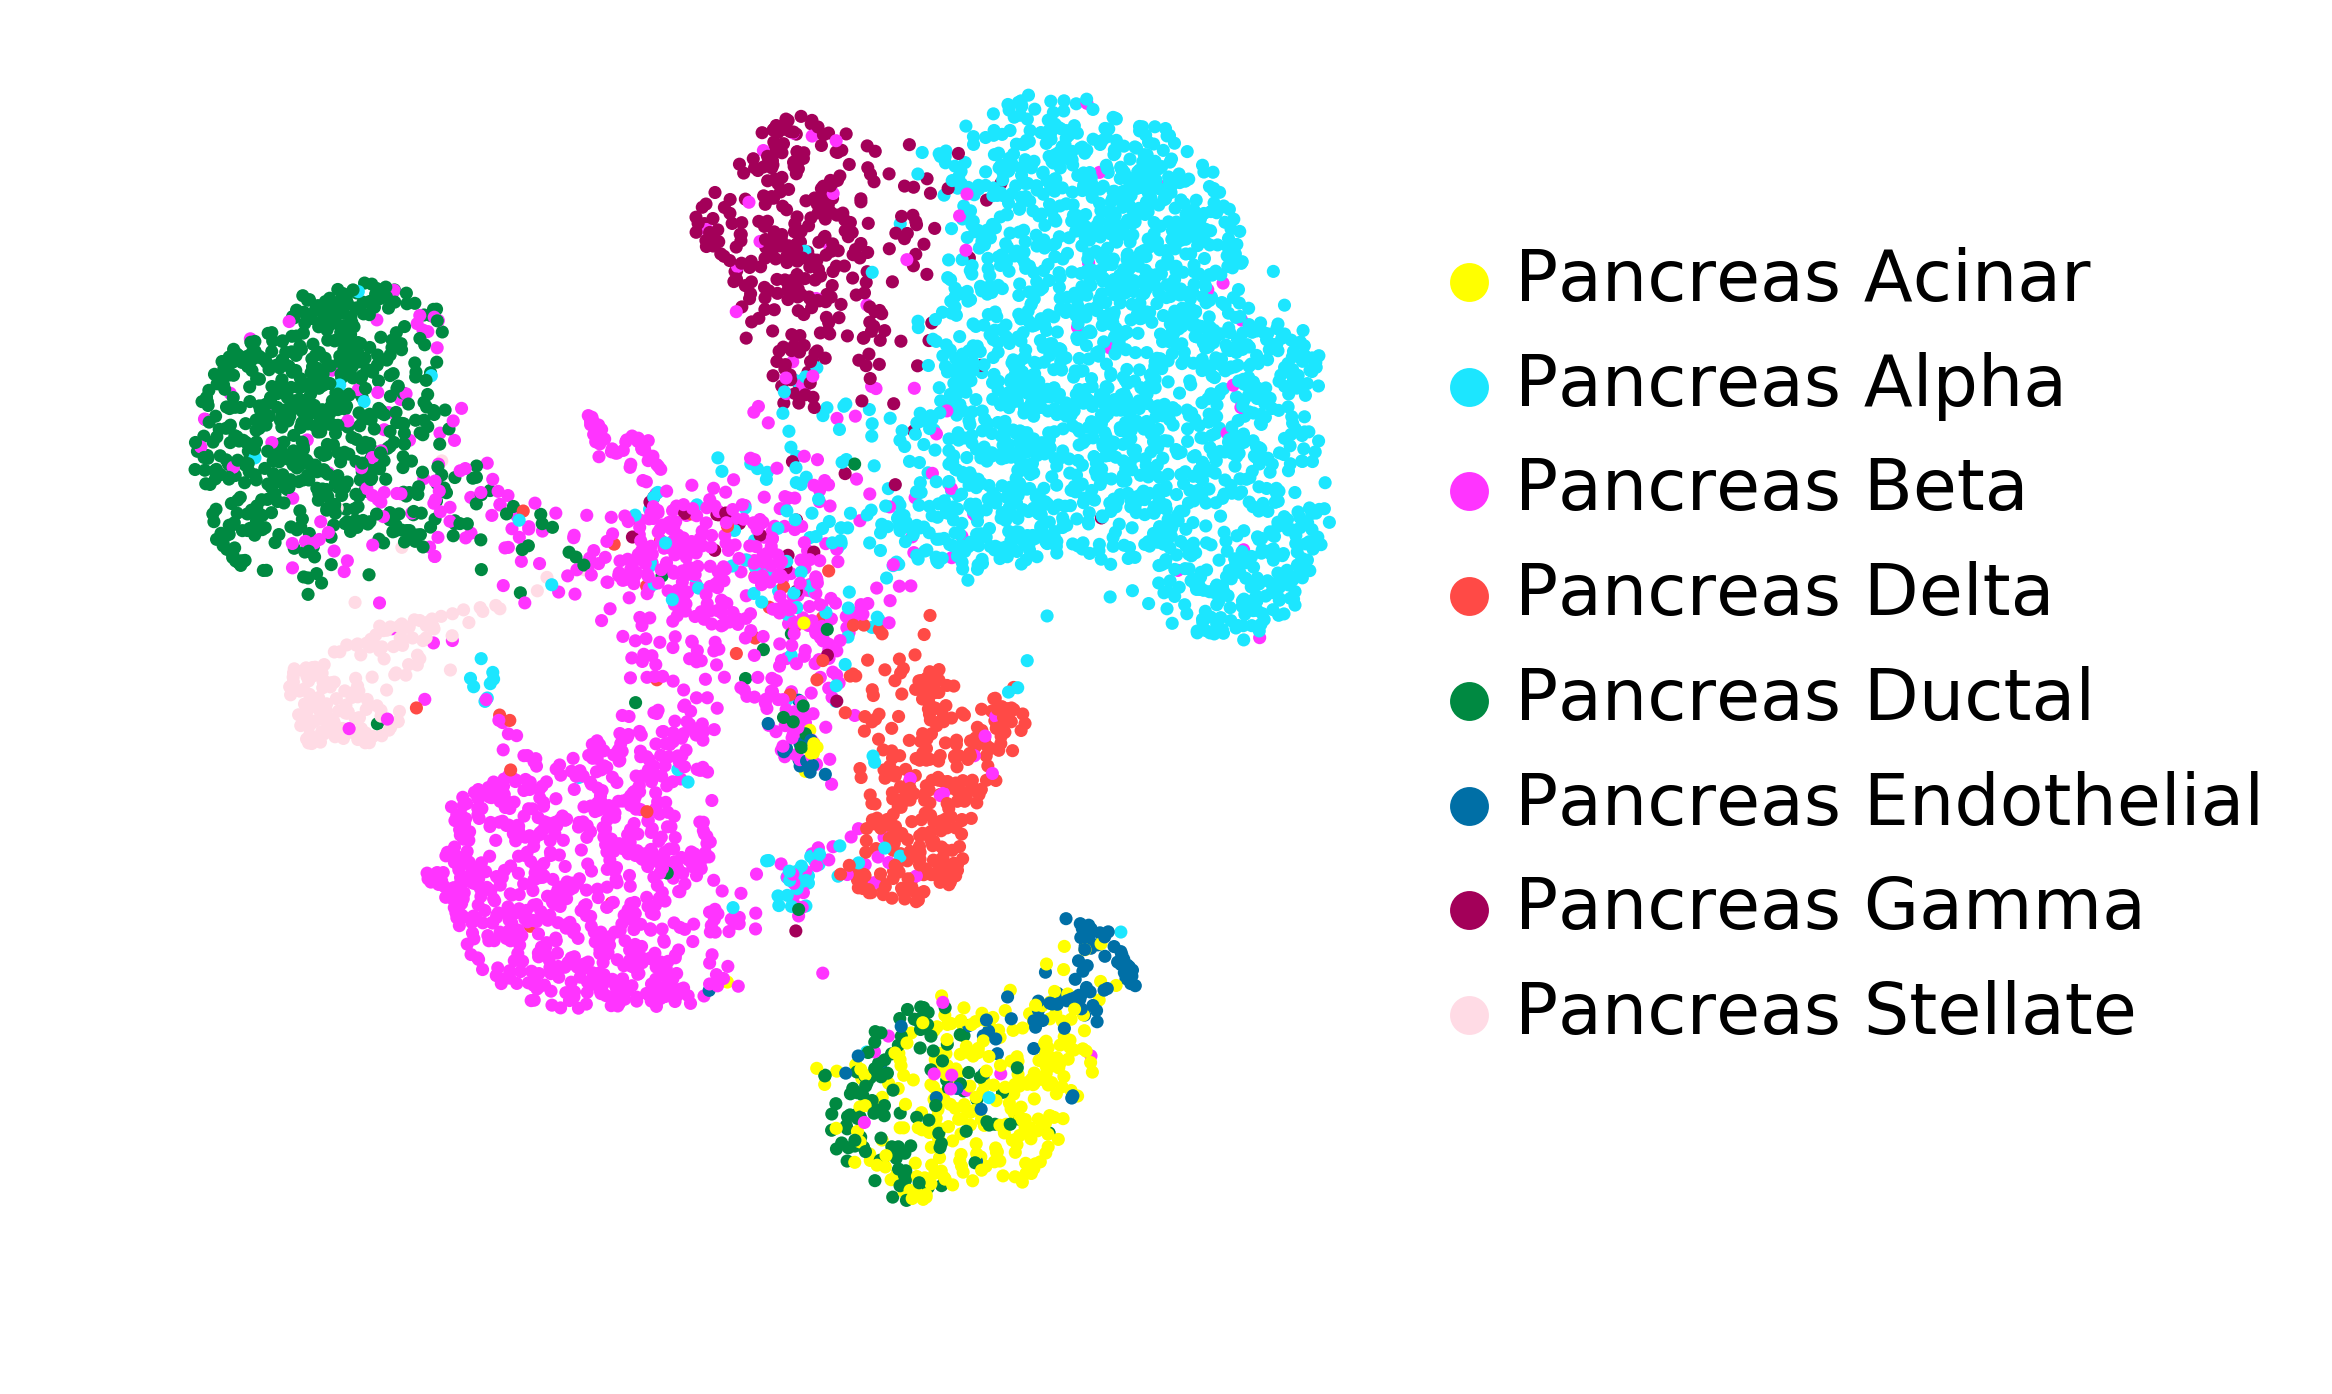

In [41]:
sc.pl.umap(latent_adata_after, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_out_of_sample_after.pdf", palette=sc.pl.palettes.godsnot_102)

# Let's see what has happened for the target cell type! :)

In [26]:
plot_adata = adata_for_training.concatenate(adata_out_of_sample)
plot_adata

AnnData object with n_obs × n_vars = 12971 × 1000 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [27]:
latent_adata = new_network.get_latent(plot_adata, condition_key, return_z=False)
latent_adata

AnnData object with n_obs × n_vars = 12971 × 20 
    obs: 'batch', 'cell_type', 'size_factors', 'study'

In [37]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

... storing 'cell_type' as categorical
... storing 'study' as categorical


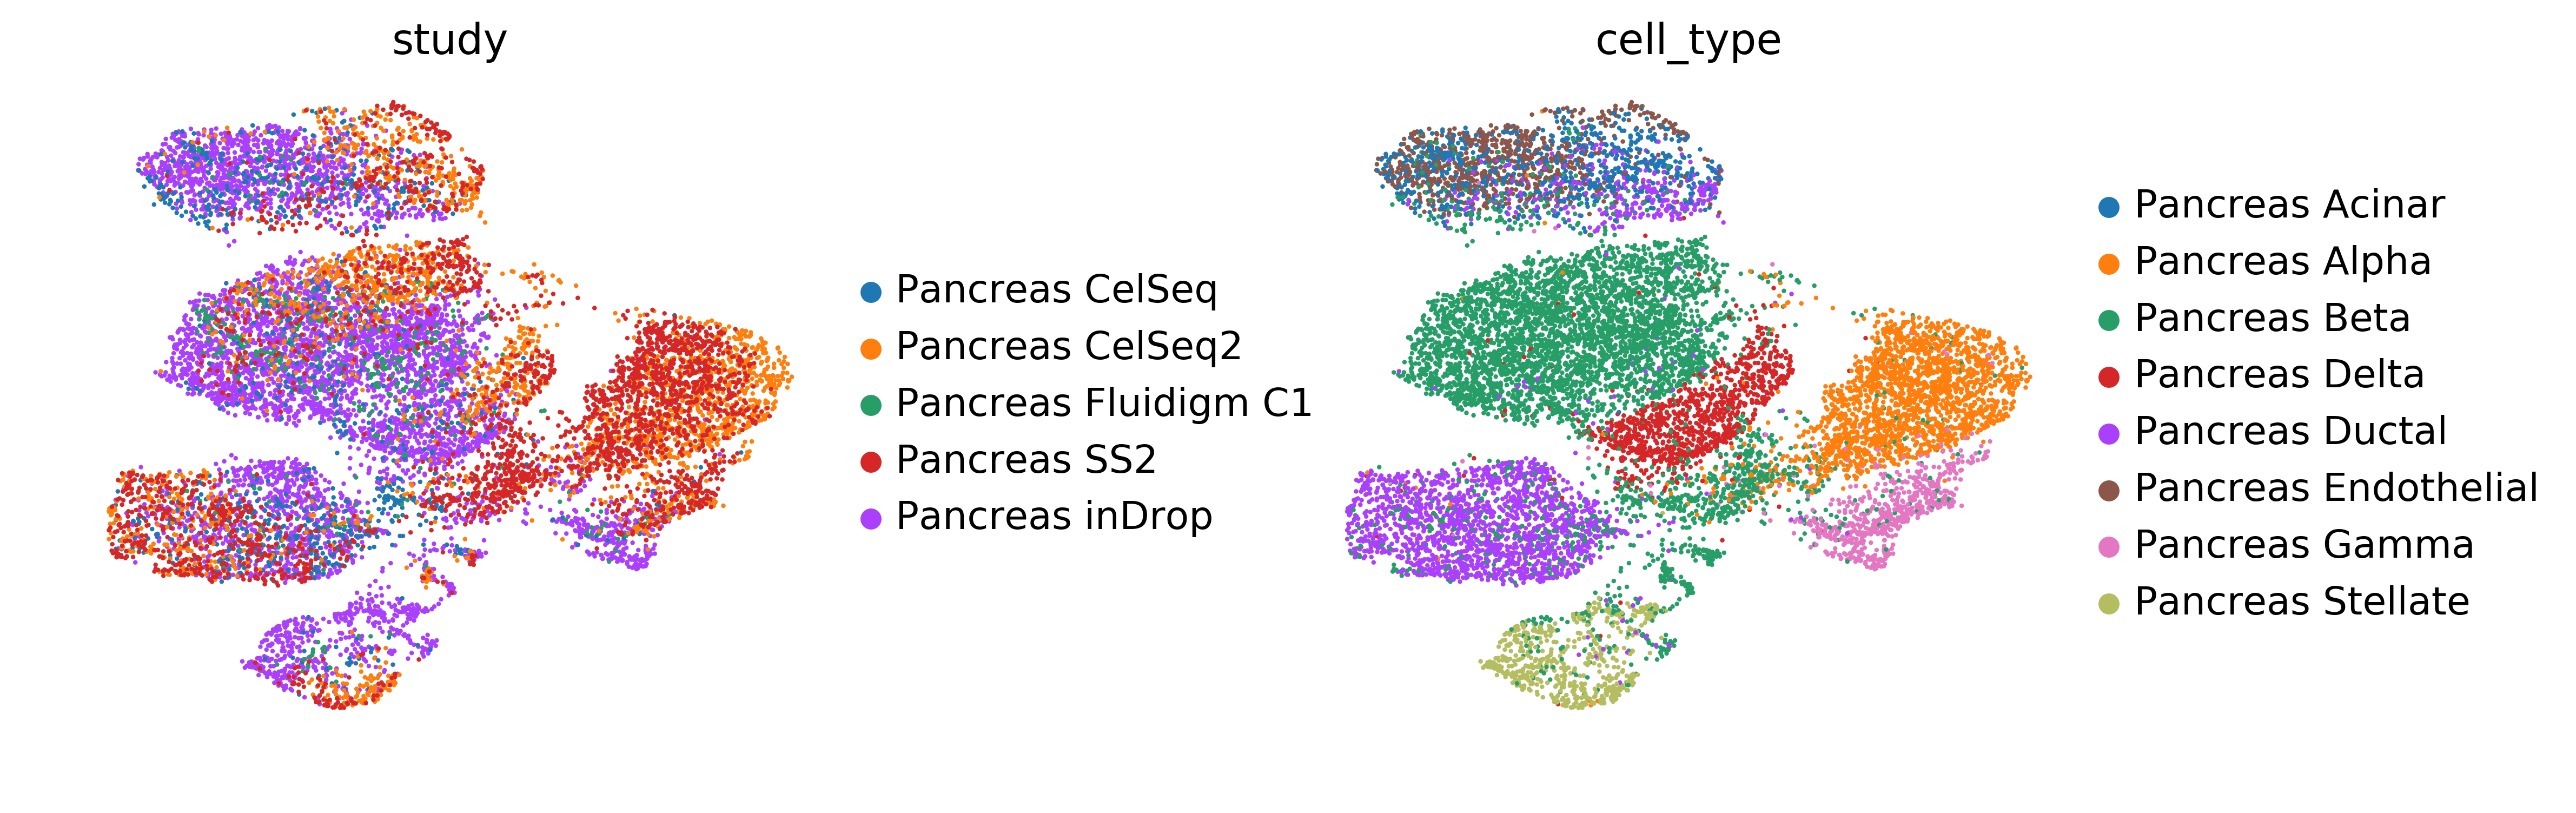

In [38]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], wspace=0.5, frameon=False, )

In [37]:
palette = batch_colors

... storing 'cell_type' as categorical
... storing 'study' as categorical


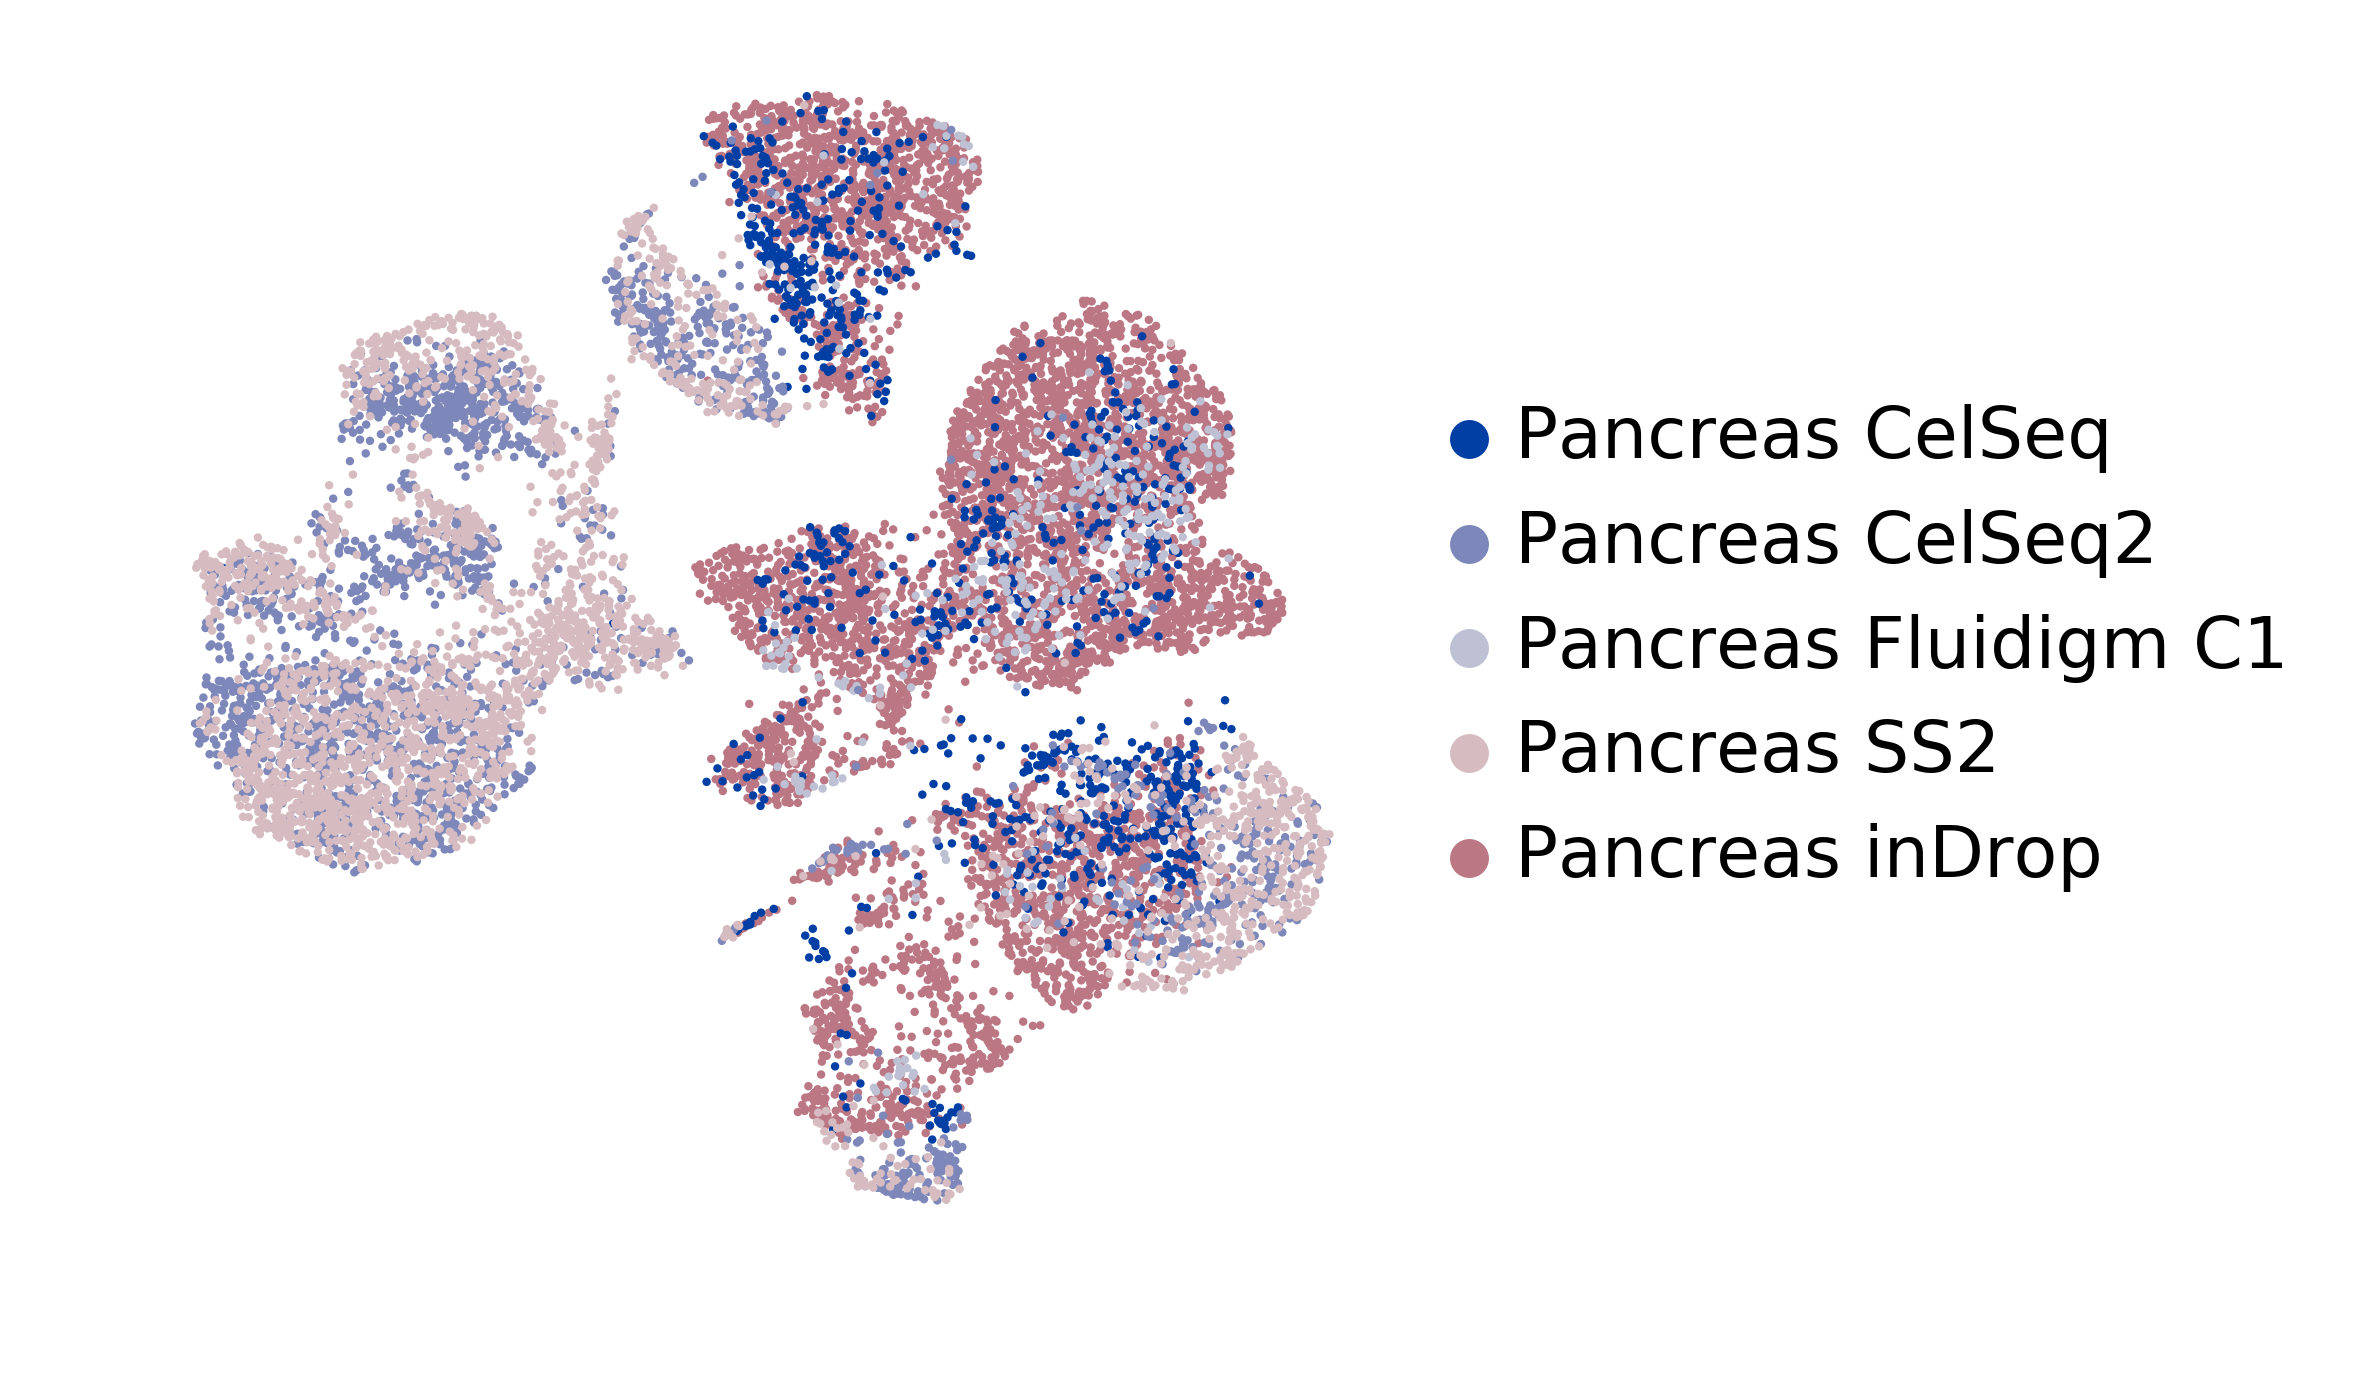

In [38]:
sc.pl.umap(latent_adata, color=[condition_key], frameon=False, title="", 
           save="_condition_all_after.pdf", palette=palette)

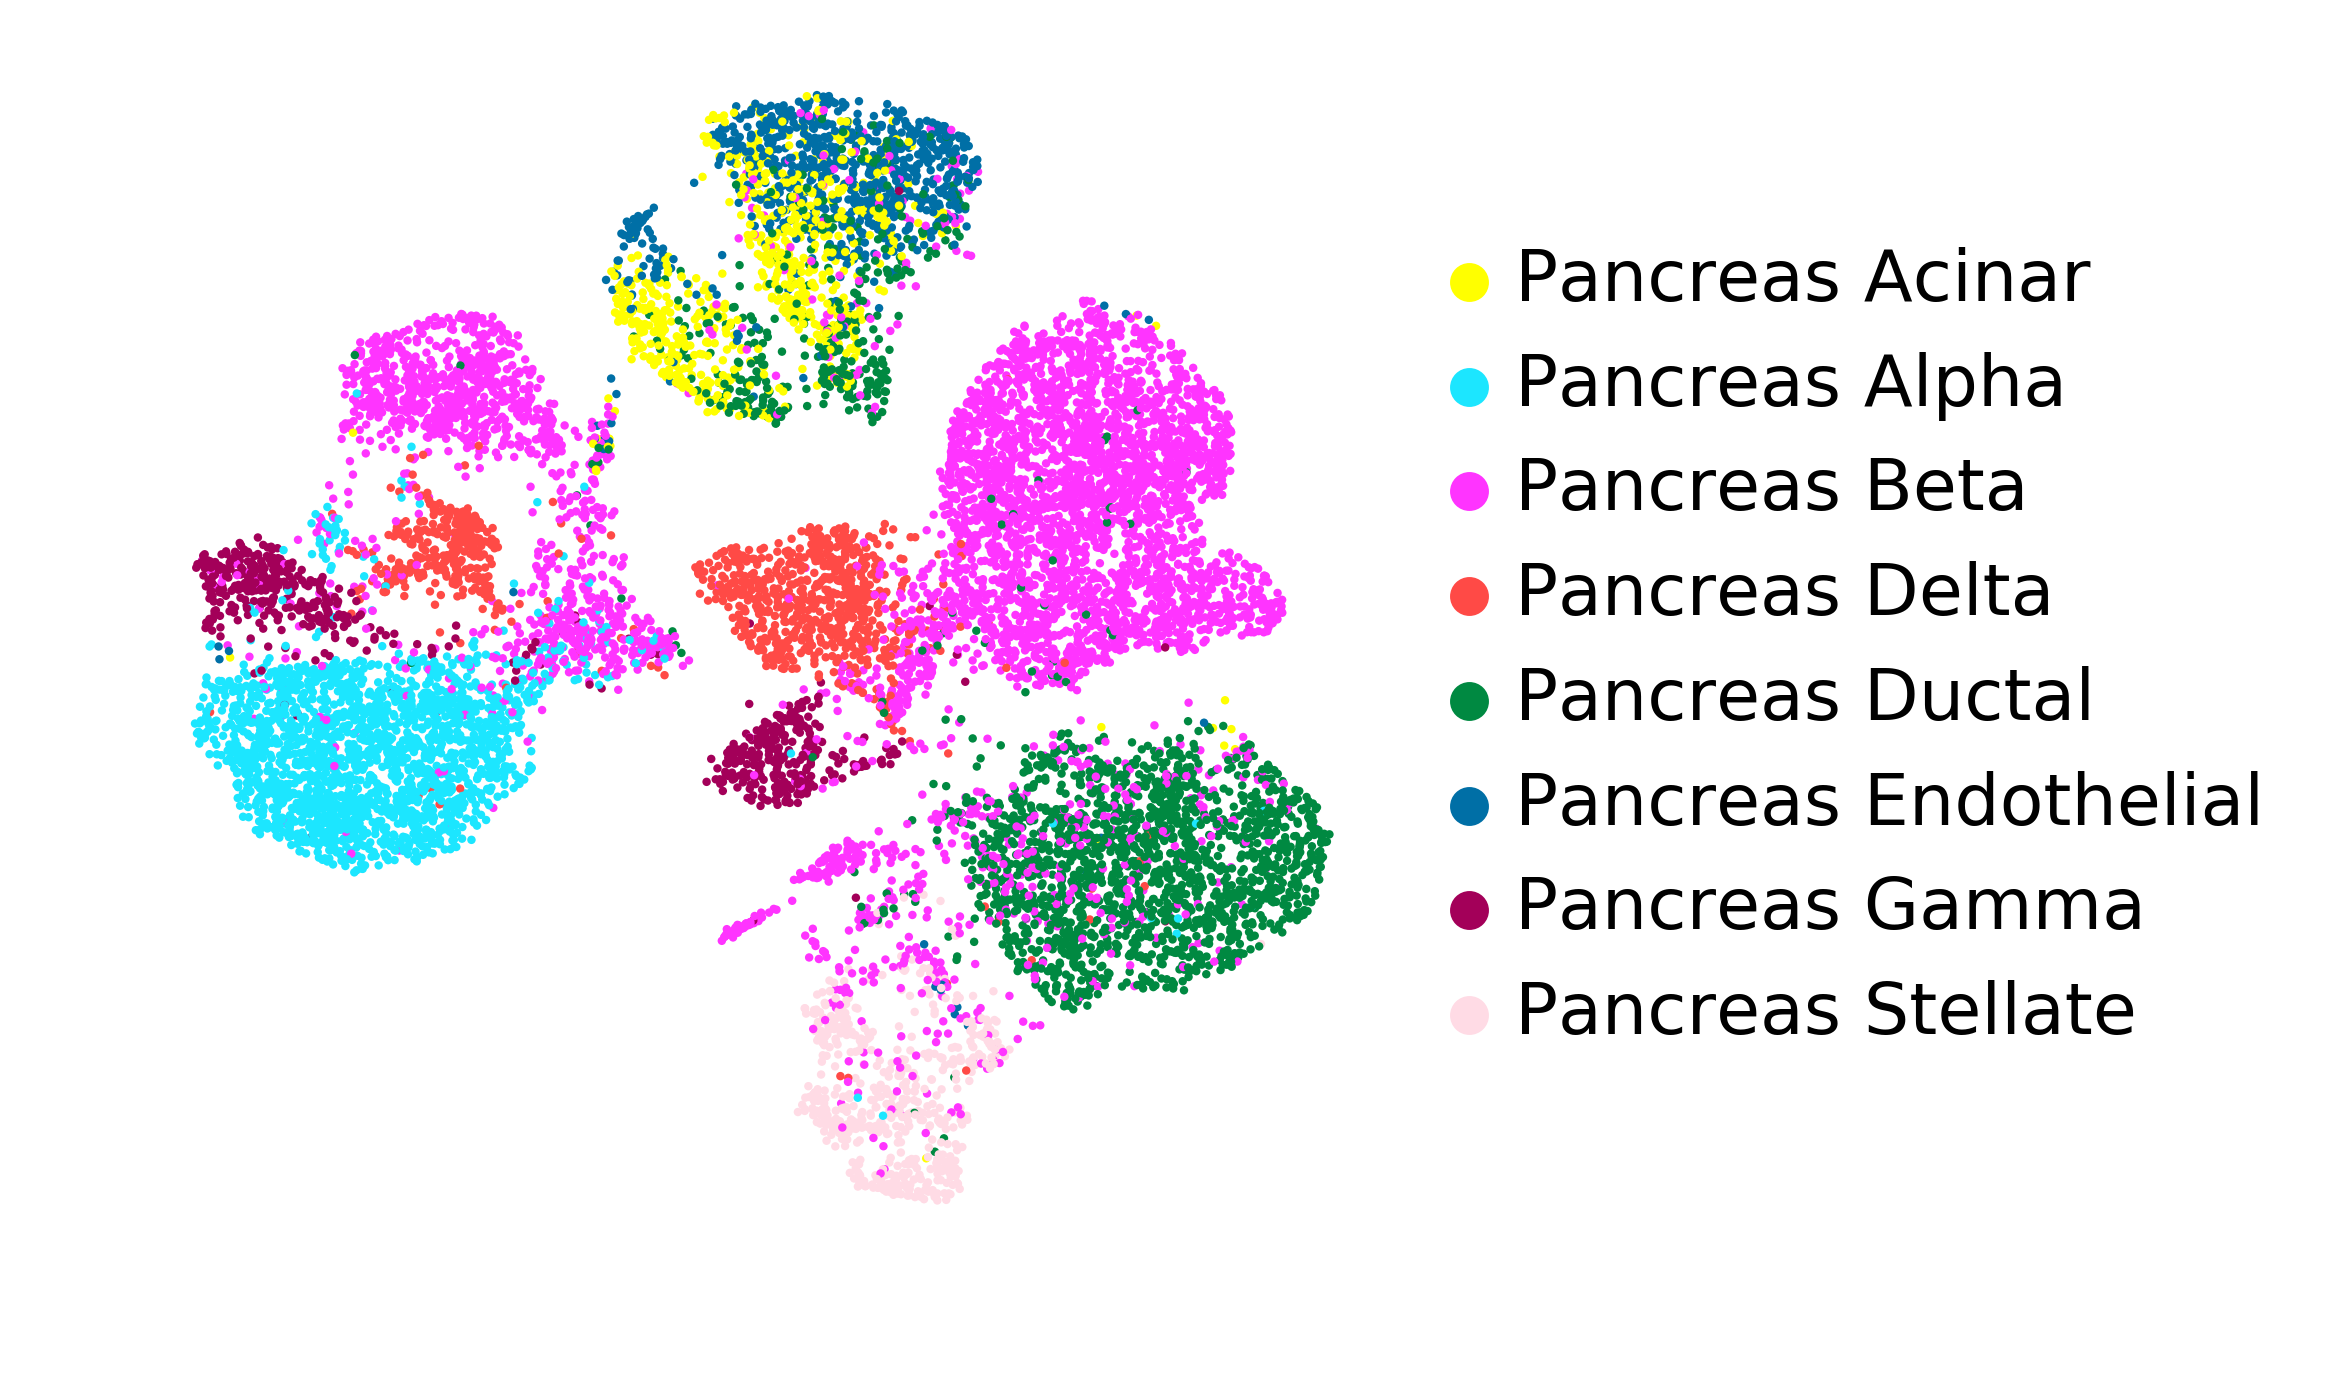

In [39]:
sc.pl.umap(latent_adata, color=[cell_type_key], frameon=False, title="", 
           save="_cell_type_all_after.pdf", palette=sc.pl.palettes.godsnot_102)